# **ENVIRONMENT**


Consider the problem of day-to-day control of an inventory of a fixed maximum size in the face of uncertain demand: 
* Every evening, the decision maker must decide about the quantity to be ordered for the next day. 
* In the morning, the ordered quantity arrives with which the inventory is filled up. 
* During the day, some stochastic demand is realised, where the demands are independent with a common fixed distribution.

The goal of the inventory manager is to manage the inventory so as to maximize the present monetary value of the expected total future income.





---
This environment has the following state, actions and reward:
* State: size of the inventory at the end of the day
* Action: how many items to order for the subsequent day (assumed to only occur once, at the end of the day)
* Reward: profit/payoff at the end of the day

There is no terminal state, and maximum inventory size is determined by the user.


---
The profit/payoff is determined by deducting three costs from the revenue gained, which are:
1. Fixed entry cost - cost of ordering non-zero items (one price regardless of order size)
2. Purchase cost - each item must be purchased at a fixed price
3. Holding cost - cost of holding each item in the inventory

Therefore:
$$ \text{Profit} = \text{Revenue} - \text{Fixed entry cost} - \text{Purchase cost} - \text{Holding cost}$$

Costs and revenue (i.e. selling price per item) are likewise determined by the user, although naturally selling price has to be greater than the purchase cost for there to be an incentive.

---

The transition function from day to day (i.e. current State to next State) is determined by simulating the uncertain/stochastic demand, by randomly sampling from a Poisson distribution.

Poisson distribution is determined by a single parameter lambda, which represents the average demand. This is determined, a priori, by the user.

---
---

Notes

* This environment is based on the "Inventory control
with lost sales" problem described in Example 1.1 in 
[Algorithms for Reinforcement Learning by Csaba Szepesvari (2010)](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf).

* Credit for the original environment to [paulhendricks](https://github.com/paulhendricks/gym-inventory)
---

In [1]:
import gym
from gym import spaces
from gym import utils
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = logging.getLogger(__name__)


class InventoryEnv(gym.Env, utils.EzPickle):
    """
    Inventory control with lost sales environment

    ---
    State: inventory size (at end of day{t})
    Action: number of items ordered (after end of day{t})
    Reward: Profit made on the following day (day{t+1})

    ---
    init arguments:
    - n: maximum inventory size. also equivalent to the Action & Observation spaces, and initial State space. copied into self.max_inv attribute. default = 100.
    - k: fixed entry cost of ordering non-zero items. default = 5.
    - c: fixed purchased price of each item. default = 2.
    - h: proportionality cost factor of holding an inventory of any given size. default = 2.
    - p: monetary amount paid for  (a.k.a. selling price of) each unit of item sold. p must be more than h, otherwise there is no incentive to order new items. default = 3.
    - lam: lambda parameter for the Poisson stochastic-demand process. Represents expected (i.e. average) units sold per day. default = 8.

    ---
    TO BE EDITED
    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    def __init__(self, n=100, m=100, k=5, c=2, h=2, p=3, lam=8, seed=None):
        assert p > h, "price (p) less than holding cost factor (h)"
        self.n = n
        self.action_space = spaces.Discrete(m)
        self.observation_space = spaces.Discrete(m)
        self.max_inv = m
        self.state = n
        self.k = k
        self.c = c
        self.h = h
        self.p = p
        self.lam = lam

        # trends
        self.timestep = 0
        self.trend = 1
        self.trend_lim = 0.5

        # Set seed
        # self._seed()
        self.rng = np.random.default_rng(seed)
        
        # Start the first round
        self.reset()

    def _demand(self):
        self.timestep += 1

        return np.random.poisson(self.lam)
        # return np.random.poisson(self.lam + trend)
        # return self.rng.poisson(self.lam * self.trend)

    def _transition(self, x, a, d):
        '''
        transition dynamics function; returns size of the next inventory (i.e. next state)
        '''
        m = self.max_inv
        return max(min(x + a, m) - d, 0)

    def _reward(self, x, a, y):
        '''
        input
        - x: state
        - a: action
        - y: next state

        returns
        - profit (i.e. reward)
        ---
        profit (reward) is calculated as follows
        profit = - fixed entry cost - purchase cost - holding cost + revenue
        '''

        k = self.k
        m = self.max_inv
        c = self.c
        h = self.h
        p = self.p
        r = - k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
        return r

    # def _seed(self, seed=None):
    #     self.np_random, seed = seeding.np_random(seed)
    #     return [seed]

    def step(self, action):
        assert self.action_space.contains(action), "invalid action"
        obs = self.state
        demand = self._demand()
        obs2 = self._transition(obs, action, demand)
        self.state = obs2
        reward = self._reward(obs, action, obs2)
        done = 0

        # #incentive tracking
        # if obs > demand: #if demand is (more than) met
        #   self.trend = min(self.trend + .05, 1 + self.trend_lim)
        # else: #if obs < demand: #if supply < demand
        #   self.trend = max(self.trend - .05, 1 - self.trend_lim)

        return obs2, reward, done, {'demand':demand}

    def reset(self):
        self.state = self.n
        self.timestep = 0
        return self.state

# **ACTOR-CRITIC**

*Proximal Policy Optimisation* (PPO) will be used to train the agent.
This is an Actor-Critic algorithm, meaning that there will be a pair of interleaved models training with each other. 

The *Actor* learns the policy mapping, i.e. mapping States to Actions

The *Critic* learns the value function, i.e. mapping States to expected future Rewards

---

RL uses SL methods to train the Actor & Critic networks.

The Buffer acts as the "dataset" in this case, where it keeps a store of States, Actions and Rewards (and their associated derivatives) for training.

The Buffer has a FIFO structure, where newer training instances will overwrite older instances the longer the training iterations go on.

Actor/Critic networks will randomly sample past experiences from the Buffer, to form their "features" and "targets" for training/updating weights.

---

The remaining functions are helper/constructor functions necessary for the whole PPO flow

---
---

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import clone_model
import matplotlib.pyplot as plt
import scipy.signal
import time
import scipy as sp

In [3]:
# replay buffer
class Buffer:
    # Buffer for storing trajectories
    def __init__(self, size, observation_dimensions, gamma=0.99, lam=0.95):
        '''
        size: size of the buffer (i.e. no. of records to keep in buffer)
        observation_dimensions: dimension of the observation/State
        gamma: discount factor, default 0.99
        lam: smoothing parameter to reduce the variance in training, default 0.95
        '''
        # Buffer initialization
        self.observation_buffer = np.zeros((size, observation_dimensions), dtype=np.float32)
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

        # if self.pointer >= self.observation_buffer.shape[0]:
        #     self.pointer = 0

    def discounted_cumulative_sums(self, x, discount):
        # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
        return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = self.discounted_cumulative_sums(deltas, self.gamma * self.lam)
        self.return_buffer[path_slice] = self.discounted_cumulative_sums(rewards, self.gamma)[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0

        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )

In [4]:
# Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
# masked by one-hot encoding
def logprobabilities(logits, a):
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability

In [5]:
# Sample action from actor
@tf.function
def sample_action(actor,observation):
    logits = actor(observation)
    action = tf.squeeze(tf.random.categorical(logits, 1), axis=1)
    # action = tf.math.argmax(tf.nn.sigmoid(logits),axis=1) # best action
    return logits, action

In [6]:
# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(observation_buffer, action_buffer, logprobability_buffer, advantage_buffer):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(logprobabilities(actor(observation_buffer), action_buffer) - logprobability_buffer)
        
        #clip objective
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(tf.minimum(ratio * advantage_buffer, min_advantage))

    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(logprobability_buffer - logprobabilities(actor(observation_buffer), action_buffer))
    kl = tf.reduce_sum(kl)
    return kl

In [7]:
# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [8]:
# neural network builder
def mlp(x, sizes, activation=tf.tanh, l2=0.01, output_activation=None):
    '''
    Build a feedforward neural network

    x: input size
    sizes: no. of nodes per layer (incld. output layer), pass in as iterable
    activation: activation function (only for hidden layers); pass in as tensorflow object; default "tanh"
    l2: L2-regularisation hyperparameter (only for hidden layers); pass in as float
    output_activation: activation for output layer, pass in as tensorflow object; default "None"
    '''   
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation,kernel_regularizer=regularizers.L2(l2))(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)

# **TRAINING**

Implementation of the PPO algorithm



In [9]:
# Hyperparameters/settings
steps_per_epoch = 1000 #500
epochs = 500 #1000
gamma = .7 #.99 #discount factor (0.99 best)
clip_ratio = .2 #upper/lower limit of PPO-Clip
policy_learning_rate = 3e-4 #learning rate of policy network
value_function_learning_rate = 1e-3 #learning rate of value network
train_policy_iterations = 80
train_value_iterations = 80
lam = 0.97 #smoothing parameter used for reducing the variance in training (in Buffer class)
target_kl = .01
history_to_remember = 21
l2 = .001 #.0001
hidden_sizes = (64,64,64) #(32,32,64,64) #(64,128)
starting_inventory = 0

## True if you want to render the environment
#render = False 

In [ ]:
# Initialize the environment, and get the dimensionality of the observation space and the number of possible actions
env = InventoryEnv(n = starting_inventory)
observation_dimensions = history_to_remember #env.observation_space.shape[0]
num_actions = env.action_space.n

# Initialize the buffer
buffer = Buffer(steps_per_epoch, observation_dimensions)

# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype=tf.float32)

# Policy function (actor)
logits = mlp(observation_input, list(hidden_sizes) + [num_actions], tf.tanh, l2, None) 
actor = keras.Model(inputs=observation_input, outputs=logits)

# Value function (critic)
value = tf.squeeze(mlp(observation_input, list(hidden_sizes) + [1], tf.tanh, l2, None), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=policy_learning_rate)
value_optimizer = keras.optimizers.Adam(learning_rate=value_function_learning_rate)

While training the Actor, a copy of the network that produces the highest reward (regardless of training epoch) is also kept, and labelled "Best Actor"

In [ ]:
# keep copy of best performing model
best_actor = clone_model(actor)
best_performance = -np.inf

# Initialize the observation, episode return and episode length
observation_new = env.reset()
observation = np.array([observation_new]*observation_dimensions)
episode_return, episode_length = 0, 0

# Iterate over the number of epochs
for epoch in range(epochs):
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        #if render: env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(actor,observation)
        observation_new, reward, done, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        #observation = observation_new
        observation = np.append(observation.flatten()[1:],observation_new)

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1): #if done, or last iteration of loop
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation_new = env.reset()
            observation = np.array([observation_new]*observation_dimensions)
            episode_return, episode_length = 0, 0
            break

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(observation_buffer, action_buffer, logprobability_buffer, advantage_buffer)
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # save best performing model
    performance = sum_return / steps_per_epoch
    if performance > best_performance:
      best_actor.set_weights(actor.get_weights())
      best_performance = performance

    # Print mean return and length for each epoch
    if (epoch % 50) == 0:
        print(f" Epoch: {epoch + 1}. Mean Return: {performance}. Mean Length: {sum_length / num_episodes}.")

print('best Mean Return: ', best_performance)

 Epoch: 1. Mean Return: -5.118. Mean Length: 30.0.
 Epoch: 51. Mean Return: -5.145. Mean Length: 29.0.
 Epoch: 101. Mean Return: -5.053. Mean Length: 28.0.
 Epoch: 151. Mean Return: -5.125. Mean Length: 30.0.
 Epoch: 201. Mean Return: -5.083. Mean Length: 28.0.
 Epoch: 251. Mean Return: -5.036. Mean Length: 28.0.
 Epoch: 301. Mean Return: -5.041. Mean Length: 28.0.
 Epoch: 351. Mean Return: -5.032. Mean Length: 28.0.
 Epoch: 401. Mean Return: -5.02. Mean Length: 28.0.
 Epoch: 451. Mean Return: -5.175. Mean Length: 29.0.
 Epoch: 501. Mean Return: -5.178. Mean Length: 29.0.
 Epoch: 551. Mean Return: -5.051. Mean Length: 28.0.
 Epoch: 601. Mean Return: -5.093. Mean Length: 29.0.
 Epoch: 651. Mean Return: -5.075. Mean Length: 29.0.
 Epoch: 701. Mean Return: -5.134. Mean Length: 35.0.
 Epoch: 751. Mean Return: -5.03. Mean Length: 80.0.
 Epoch: 801. Mean Return: 0.0. Mean Length: 1000.0.
 Epoch: 851. Mean Return: 0.0. Mean Length: 1000.0.
 Epoch: 901. Mean Return: 0.0. Mean Length: 1000.0.
 

---

Note for this section, training output is a work in progress, and does not reflect the training performance of saved models. 

---

# **MODEL SAVING**


In [ ]:
# SAVING ##
to_save_model = False #change to True when want to save

if to_save_model:
  #mount gdrive
  from google.colab import drive
  drive.mount('/drive')

  #SAVE DIRECTORY
  SAVEDIR = '/drive/My Drive/RL_models/inventory_env/'

  actor.save(SAVEDIR+'actor_64x64x64_start0/')
  best_actor.save(SAVEDIR+'best_actor_64x64x64_start0/')
  critic.save(SAVEDIR+'critic_64x64x64_start0/')

# **MODEL LOADING**

In [14]:
# LOADING ##
to_load_model = False #change to True when want to load

if to_load_model:
  #mount gdrive
  from google.colab import drive
  drive.mount('/drive')

  #SAVE DIRECTORY
  SAVEDIR = '/drive/My Drive/RL_models/inventory_env/'

  # load model
  actor = keras.models.load_model(SAVEDIR+'actor_64x64x64_start0/')
  best_actor = keras.models.load_model(SAVEDIR+'best_actor_64x64x64_start0/')

  # misc
  observation_dimensions = history_to_remember

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# **TESTING**

Testing the trained Actor against a rationally-acting Human baseline.

---

To demonstrate the utility of the trained RL agent, it would have to be compared against a baseline.

The baseline should be thought of as the actions that a Human would rationally take when faced with this inventory control problem.

---

**Modelling expected actions to be taken by a Human.**

What would a person do?

It would be natural to aim for enough inventory to meet the expected demand. It would be impractical to predict daily demand (disregarding even the stochastic simulation) since there would always be noise in natural phenomena. It would also *not* make sense to keep extra inventory above what is necessary, since it would incur holding costs (and so reduce profits).

Daily demand $D$ can be estimated by subtracting the end-of-day inventory size from the previous day, 

$$\hat{D} \approx S + A - S'$$

Expected demand should then be the average of demand across all days (which can be implemented as a moving average).

$$\bar{D}_{t} = \bar{D}_{t-1} + \frac{\hat{D}_{t} - \bar{D}_{t-1}}{t} $$

However, note that demand can be accurately estimated only if subsequent day's inventory $S'$ greater than $0$,

$$\hat{D} = S + A - S',\ \text{if} \ S' > 0$$

If $S' = 0$ then it means that the demand is only *at least* previous day's inventory + action, i.e. 

$$\hat{D} \geq S + A,\ \text{if} \ S' = 0$$


Unfortunately, $S' > 0$ means that there would be excess inventory, implying holding costs, and thus cutting into revenue.

The dilemma then is to either keep elevated inventory for accurate demand estimation, or keep just enough inventory but poorly estimate demand over time.

---

The current implementation is to thus take a fixed action over some initial period of time, and keep track of average demand only when $S' > 0$. Subseqeuntly, order enough inventory to meet expected demand (i.e. top up stock when low, but only until expected demand), and continue keeping track of average demand only when $S' > 0$.

E.g., for the first 100 days, order 10 units per day; keep track of average demand $\bar{D}$ only when $S' > 0$. From day 101 onwards, order $max(\bar{D} - S,0)$ units, and continue keeping track (i.e. averaging) of $\bar{D}$ only when $S' > 0$.

Multiple experiments would be ran, across a range of fixed actions and exploration periods, to determine the best values. These values would then be used to construct a baseline.

---

In [17]:
## plotting function
def plot_rewards(S,A,R):
    t = np.arange(len(R))
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('episode')
    ax1.set_ylabel('Reward', color=color)
    ax1.plot(t, R, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Inventory', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, S[1:], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [10]:
# human behaviour
def human_performance(seed,days,starting_inv=None,starting_order=0,additional_order=0,prop_explore=0,to_plot=False):
  '''
  logic: if inventory at end of day is 0, order the average demand for the next day
  '''
  # setup
  if starting_inv is None:
    env = InventoryEnv(seed=seed)
  else:
    env = InventoryEnv(n=starting_inv,seed=seed)

  observation_new = env.reset()
  SS_ = [observation_new]
  AA_ = []
  RR_ = []
  DD_ = []
  avg_demand = 0

  # exploration parameters
  assert (prop_explore >= 0) & (prop_explore <= 1), 'prop_explore must be between 0 and 1 (inclusive)' 
  explore_days = round(days * prop_explore)

  if starting_inv == 0: assert starting_order > 0, 'starting order must be greater than 0'

  # run test
  for t in range(days): 
    if t < explore_days: # exploration days
      if observation_new < starting_order:
        action = starting_order - observation_new
      else:
        action = 0
    else: #subsequent days, stop exploring
      if observation_new < avg_demand:
        action = round(avg_demand + additional_order) - observation_new
      else:
        action = 0

    observation_new, reward, _, demand = env.step(action) 
    
    SS_.append(observation_new)
    AA_.append(action)
    RR_.append(reward)
    DD_.append(demand['demand'])
    
    obs_demand = SS_[-2] + action - observation_new

    # simple moving average (works better than EWMA)
    # avg_demand += (obs_demand - avg_demand)/(t+1)
    if observation_new > 0: avg_demand += (obs_demand - avg_demand)/(t+1) 

    # exponentially weighted moving average
    # alpha = 2/(1+history_to_remember)
    # avg_demand = (obs_demand * alpha) + (avg_demand * (1 - alpha))  
    # if observation_new > 0: avg_demand = (obs_demand * alpha) + (avg_demand * (1 - alpha))
    

  if to_plot: 
    print('Expected human behaviour - mean reward: ', np.mean(RR_))
    plot_rewards(SS_,AA_,RR_)

  return np.mean(RR_), {'states':SS_,'actions':AA_,'rewards':RR_,'demands':DD_,'observed demand':avg_demand}

In [16]:
# find best human hyperparameters
def find_best_human_hyperparameters(days = 1000,starting_inv = 0,n_tests = 50):
  import pandas as pd
  print('running tests',n_tests,'times')

  # setup search space
  seeds = np.arange(round(n_tests*10))
  np.random.default_rng().shuffle(seeds)
  seeds = seeds[:n_tests]

  starting_orders = np.arange(5,20)
  prop_explores = np.arange(.01,.2,.01)

  # run tests
  performance = {s:{p:np.nan for p in prop_explores} for s in starting_orders}
  for starting_order in starting_orders:
    for prop_explore in prop_explores:
      avg = 0
      for itr,seed in enumerate(seeds):
        hmn,_ = human_performance(seed,days,starting_inv=starting_inv,starting_order=starting_order,prop_explore=prop_explore,to_plot=False)
        avg += (hmn - avg)/(itr+1)

      performance[starting_order][prop_explore] = avg

  # results
  performance = pd.DataFrame(performance)
  
  best_starting_order = performance.max(axis=0).idxmax()
  best_prop_explore = performance.max(axis=1).idxmax()
  #performance.where(performance == performance.max().max(), inplace=True)
  
  assert performance[best_starting_order][best_prop_explore] == performance.max().max(), 'value not found'
  print('best performance:',performance.max().max())
  print('best starting order:',best_starting_order, 'best exploration:', best_prop_explore)
  
  return best_starting_order, best_prop_explore, performance

#####
starting_order,prop_explore,_ = find_best_human_hyperparameters(n_tests = 100)

running tests 100 times
best performance: -0.21807000000000007
best starting order: 11 best exploration: 0.04


In [11]:
starting_order,prop_explore = 11, 0.04

In [15]:
# function used to test Actor
def actor_performance(seed,actor,days,starting_inv=None,to_plot=False):
  
  if starting_inv is None:
    env = InventoryEnv(seed=seed)
  else:
    env = InventoryEnv(n=starting_inv,seed=seed)
  
  observation_new = env.reset()
  observation = np.array([observation_new]*observation_dimensions)

  S = [observation_new]
  A = []
  R = []
  D = []

  for t in range(days): 
    observation = observation.reshape(1, -1)
    _, action = sample_action(actor,observation)
    observation_new, reward, _, demand = env.step(action[0].numpy()) 
    
    S.append(observation_new)
    A.append(action[0].numpy())
    R.append(reward)
    D.append(demand['demand'])
  
    # Update the observation
    observation = np.append(observation.flatten()[1:],observation_new)

  if to_plot: 
    print('Actor performance - mean reward: ', np.mean(R))
    plot_rewards(S,A,R)

  return np.mean(R), {'states':S,'actions':A,'rewards':R,'demands':D} #(S,A,R)

Test one instance to illustrate the Actor (& Best Actor's) performance against a Human baseline.


ACTOR
Actor performance - mean reward:  0.315


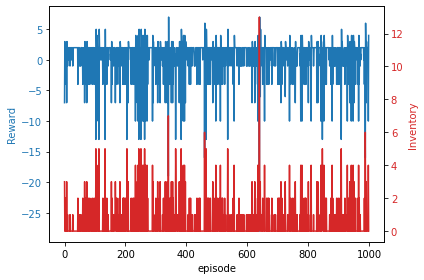

proportion of inactions:  0.284
average demand:  7.978
----------------------------


BEST ACTOR
Actor performance - mean reward:  0.439


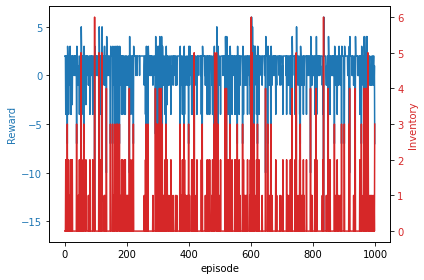

proportion of inactions:  0.321
average demand:  8.03
----------------------------


HUMAN
Expected human behaviour - mean reward:  -0.132


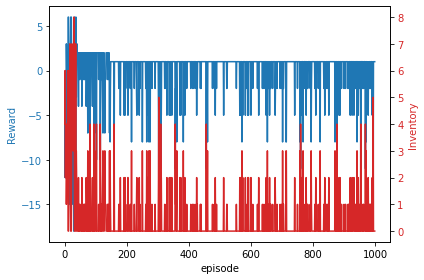

proportion of inactions:  0.0
average demand:  8.041
----------------------------



In [18]:
# test one instance
days = 1000
seed = 1

print('\nACTOR')
mn,tr = actor_performance(seed,actor,days,starting_inv=0,to_plot=True)
print('proportion of inactions: ', np.mean([a==0 for a in tr['actions']]))
print('average demand: ', np.mean(tr['demands']))
print('----------------------------\n')

print('\nBEST ACTOR')
mnb,trb = actor_performance(seed,best_actor,days,starting_inv=0,to_plot=True)
print('proportion of inactions: ', np.mean([a==0 for a in trb['actions']]))
print('average demand: ', np.mean(trb['demands']))
print('----------------------------\n')

print('\nHUMAN')
mn_,tr_ = human_performance(seed,days,starting_inv=0,starting_order=starting_order,prop_explore=prop_explore,to_plot=True)
# mn_,tr_ = human_performance(seed,days,starting_inv=0,starting_order=8,prop_explore=1,to_plot=True)
print('proportion of inactions: ', np.mean([a==0 for a in tr_['actions']]))
print('average demand: ', np.mean(tr_['demands']))
print('----------------------------\n')

In [19]:
# reviewing trajectory (trailing end)
print('states', tr_['states'][-11:])
print('actions', tr_['actions'][-10:])
print('demands', tr_['demands'][-10:])
print('observed demand: ', tr_['observed demand'])

states [0, 0, 2, 0, 1, 5, 0, 0, 0, 0, 0]
actions [6, 6, 4, 6, 5, 1, 6, 6, 6, 6]
demands [10, 4, 11, 5, 1, 10, 13, 7, 10, 10]
observed demand:  5.800957776010515


Test Actor/Best Actor's performance across multiple runs, against multiple Human baselines, for robust comparison.

In [20]:
## testing functions

# 
def test_metric(metric,results,agent='actor'):
  print('-', metric, '-')
  print('ACTOR - mean:', round(np.mean(results[agent][metric]),3), ', std:', round(np.std(results[agent][metric]),3), 
      '| HUMAN - mean:', round(np.mean(results['human'][metric]),3), ', std:', round(np.std(results['human'][metric]),3))
  t_stat,p_val = sp.stats.ttest_ind(results['actor'][metric],results['human'][metric],equal_var=False)
  print('T:', round(t_stat,3), '| p-value:', round(p_val,3), '| sig?:', p_val < .05)
  print('------')

# actor testing
def test_actor(actor,best_actor = None,days = 1000,n_tests = 500,starting_inv=None,human_starting_order=0,prop_explore=0):
  seeds = np.arange(1000)
  np.random.default_rng().shuffle(seeds)
  seeds = seeds[:n_tests]

  results = {'actor':     {'mean_reward':[],'prop_inaction':[],'avg_demand':[]},
            'best_actor':{'mean_reward':[],'prop_inaction':[],'avg_demand':[]},
            'human':     {'mean_reward':[],'prop_inaction':[],'avg_demand':[]}}

  if best_actor is None:
    best_actor = actor
    results['note'] = 'actor = best_actor'
  
  c = 0
  print('--- ongoing comparisons ---')
  for i,seed in enumerate(seeds):
    
    # actor
    actor_mean_reward, actor_trajectory = actor_performance(seed,actor,days,starting_inv=starting_inv)
    results['actor']['mean_reward'].append(actor_mean_reward)
    # results['actor']['prop_inaction'].append(np.mean([(s<=1 & a==0) for s,a in zip(actor_trajectory['states'][:-1],actor_trajectory['actions'])]))
    results['actor']['prop_inaction'].append(np.mean([a==0 for a in actor_trajectory['actions']]))
    results['actor']['avg_demand'].append(np.mean(actor_trajectory['demands']))

    # best_actor
    best_actor_mean_reward, best_actor_trajectory = actor_performance(seed,best_actor,days,starting_inv=starting_inv)
    results['best_actor']['mean_reward'].append(best_actor_mean_reward)
    # results['best_actor']['prop_inaction'].append(np.mean([(s<=1 & a==0) for s,a in zip(best_actor_trajectory['states'][:-1],best_actor_trajectory['actions'])]))
    results['best_actor']['prop_inaction'].append(np.mean([a==0 for a in best_actor_trajectory['actions']]))
    results['best_actor']['avg_demand'].append(np.mean(best_actor_trajectory['demands']))

    # human
    human_mean_reward, human_trajectory = human_performance(seed,days,starting_inv=starting_inv,starting_order=human_starting_order,prop_explore=prop_explore)
    results['human']['mean_reward'].append(human_mean_reward)
    # results['human']['prop_inaction'].append(np.mean([(s<=1 & a==0) for s,a in zip(human_trajectory['states'][:-1],human_trajectory['actions'])]))
    results['human']['prop_inaction'].append(np.mean([a==0 for a in human_trajectory['actions']]))
    results['human']['avg_demand'].append(np.mean(human_trajectory['demands']))

    c += actor_mean_reward > human_mean_reward

    if (i+1) % (n_tests/5) == 0: 
      print('iteration', i+1, ':', round(c/(i+1),3))
  
  print('\n--- TESTING METRICS ---')
  # print metrics
  for m in ['mean_reward','prop_inaction','avg_demand']:
    test_metric(m,results)

  return results

ACTOR
--- ongoing comparisons ---
iteration 10 : 1.0
iteration 20 : 1.0
iteration 30 : 1.0
iteration 40 : 1.0
iteration 50 : 0.98

--- TESTING METRICS ---
- mean_reward -
ACTOR - mean: 0.433 , std: 0.173 | HUMAN - mean: -0.254 , std: 0.155
T: 20.725 | p-value: 0.0 | sig?: True
------
- prop_inaction -
ACTOR - mean: 0.275 , std: 0.011 | HUMAN - mean: 0.001 , std: 0.001
T: 178.861 | p-value: 0.0 | sig?: True
------
- avg_demand -
ACTOR - mean: 7.978 , std: 0.096 | HUMAN - mean: 7.988 , std: 0.096
T: -0.491 | p-value: 0.625 | sig?: False
------


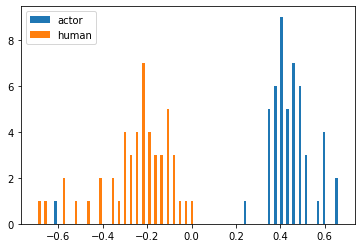

In [21]:
print('ACTOR')
results = test_actor(actor,n_tests = 50,starting_inv=0,human_starting_order=starting_order,prop_explore=prop_explore)

# plot histogram
plt.hist([results['actor']['mean_reward'], results['human']['mean_reward']], bins=50, label=['actor', 'human'])
plt.legend(loc='upper left')
plt.show()

BEST ACTOR
--- ongoing comparisons ---
iteration 10 : 1.0
iteration 20 : 0.95
iteration 30 : 0.967
iteration 40 : 0.975
iteration 50 : 0.96

--- TESTING METRICS ---
- mean_reward -
ACTOR - mean: 0.385 , std: 0.275 | HUMAN - mean: -0.236 , std: 0.138
T: 14.143 | p-value: 0.0 | sig?: True
------
- prop_inaction -
ACTOR - mean: 0.319 , std: 0.012 | HUMAN - mean: 0.0 , std: 0.001
T: 186.322 | p-value: 0.0 | sig?: True
------
- avg_demand -
ACTOR - mean: 8.007 , std: 0.096 | HUMAN - mean: 8.0 , std: 0.097
T: 0.359 | p-value: 0.72 | sig?: False
------


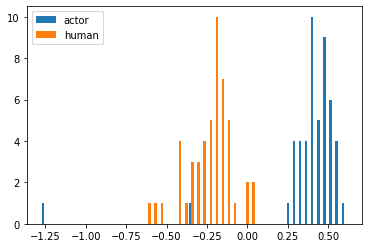

In [22]:
print('BEST ACTOR')
results_b = test_actor(best_actor,n_tests = 50,starting_inv=0,human_starting_order=starting_order,prop_explore=prop_explore)

# plot histogram
plt.hist([results_b['actor']['mean_reward'], results_b['human']['mean_reward']], bins=50, label=['actor', 'human'])
plt.legend(loc='upper left')
plt.show()

For a rather (improbable) scenario, the Actor can also be compared to an omnipotent Human agent, i.e. a Human agent that has preternaturally discerned the fixed distribution mean.

ACTOR
--- ongoing comparisons ---
iteration 10 : 1.0
iteration 20 : 1.0
iteration 30 : 1.0
iteration 40 : 1.0
iteration 50 : 1.0

--- TESTING METRICS ---
- mean_reward -
ACTOR - mean: 0.468 , std: 0.092 | HUMAN - mean: -0.37 , std: 0.13
T: 36.925 | p-value: 0.0 | sig?: True
------
- prop_inaction -
ACTOR - mean: 0.27 , std: 0.009 | HUMAN - mean: 0.0 , std: 0.001
T: 201.838 | p-value: 0.0 | sig?: True
------
- avg_demand -
ACTOR - mean: 7.989 , std: 0.094 | HUMAN - mean: 7.986 , std: 0.087
T: 0.118 | p-value: 0.906 | sig?: False
------


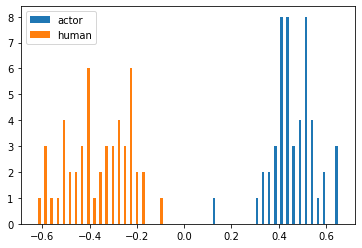

In [23]:
print('ACTOR')
results = test_actor(actor,n_tests = 50,starting_inv=0,human_starting_order=8,prop_explore=1)

# plot histogram
plt.hist([results['actor']['mean_reward'], results['human']['mean_reward']], bins=50, label=['actor', 'human'])
plt.legend(loc='upper left')
plt.show()

# **CONCLUSION**

1. We can see from the results that the Actor reliably outperforms a Human baseline, and thus a usable RL agent has been trained.

2. The Best Actor network does so as well, but it fails spectacularly on certain occasions.

3. Interestingly, the Human baseline tends to be making losses most of the time, possibly implying that the current strategy is not the best.

# MISC

In [ ]:
### illustration of running the environment with predefined actions
### can be used as a template to build the training algo around

# env = InventoryEnv(n = 0)
# obs = env.reset()
# done = False
# iter = 0 #iter counter
# max_iter = 1000

# while not done:
#   iter += 1
#   if iter > max_iter: break
#   action = (8-obs) if obs < 8 else 0 
#   obs_new, reward, done, info = env.step(action)
#   if iter % 100 == 0: print('iter:', iter, '| S:',obs, '| A:',action, "| S':", obs_new, '| R:',reward)
#   obs = obs_new

# # last iteration
# print('iter:', iter, '| S:',obs, '| A:',action, "| S':", obs_new, '| R:',reward)

In [ ]:
# scl = 365
# t = np.linspace(0,scl,scl)
# #c = np.random.normal(loc=0.2,scale=0.01,size=scl)
# #c = np.linspace(np.arcsin(0.001),np.arcsin(0.2),scl)

# s = np.random.normal(loc=0,scale=0.25,size=scl)

# plt.plot(np.sin(t*np.pi/90)+(0.2*t*np.pi/90)+s)

In [ ]:
# scl = 365
# t = np.linspace(0,scl/(10*np.pi),scl)
# p = []
# d1 = []
# d2 = []
# for x in t:
#   ps = np.random.normal(loc=np.sin(x)+(0.2*x),scale=.1)
#   p.append(ps)
#   d1.append(np.random.poisson(8+ps))
#   d2.append(np.random.poisson(8))

# plt.plot(d1)
# plt.plot(d2)

In [ ]:
# scl = 3650
# t2 = []
# p = []
# d1 = []
# d2 = []
# d3 = []
# for x in range(scl):
#   ts = x/(10*np.pi)
#   t2.append(ts)
#   #ps = np.random.normal(loc=np.sin(ts)+(0.2*ts),scale=1)
#   #ps = np.random.normal(loc=ts+(0.2*ts),scale=1)
#   ps = np.sin(ts)+(0.2*ts)
#   p.append(ps)
#   d1.append(np.random.poisson(8+ps))
#   d2.append(np.random.poisson(8))
#   d3.append(np.random.poisson(8+np.random.normal(ps,scale=1)))

# plt.plot(d1)
# plt.plot(d3)
# plt.plot(d2)